# Code for Figure 3 and corresponding supplementary figures

In [3]:
from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention


import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap


device = 'cuda:6'

## Healthy vs. cancer (timepoint 1) MIL

In [4]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_masks=True, load_chrometrics=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:28<00:00,  5.54s/it]


In [5]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
cdf = data.info.groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]
p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    label = np.random.randint(2)
    pat = np.random.choice(pat_healthy if label == 1 else pat_cancer)
    xs = use_data[torch_random_choice(pat_lut[pat], size=bag_size)]
    yield xs.float(), torch.tensor(label).to(device)


def test_healthy_vs_cancer_bagloader(bag_size=50, reps=5, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device,
                                      transform=T.CenterCrop(28), return_chrometric=False, return_masks=False):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  if return_masks:
    use_masks = transform(data.masks[use_idx].to(device))
  if return_chrometric:
    use_chrometric = data.chrometrics.iloc[use_idx].reset_index()
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      idx = torch_random_choice(pat_idx, size=bag_size)
      xs = use_data[idx]
      label = 1 if pat[0] == 'H' else 0
      if not return_chrometric and return_masks:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'
      elif not return_chrometric and not return_masks:
        yield xs.float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'
      elif return_chrometric and return_masks:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer', use_chrometric.iloc[idx.cpu().numpy()]
      else:
        yield xs.float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer', use_chrometric.iloc[idx.cpu().numpy()]

In [6]:
def eval_model(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    for i, (bag, mask, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags, masks


def eval_model_with_chrometrics(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    chrometrics = []
    masks = []
    for i, (bag, mask, lab, pat, group, cs) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        chrometrics.append(cs)

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn

    chrometrics = pd.concat(chrometrics, ignore_index=True)
    return df, bag_zs, bags, masks, chrometrics

In [7]:
# leave one plate out model
dfs = []

for p in use_plates:
    name = f'1_16_healthy_without_plate_{p}_mil'
    test_loader = test_healthy_vs_cancer_bagloader(use_plates=[p], return_masks=True)
    df, _, _, _ = eval_model(name, test_loader) 
    df['plate'] = p
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())


eval_df = pd.concat(dfs)
diag = pd.read_csv('meta/patient_diagnosis_groups.csv').rename(columns={'patient':'pat', 'group':'diag'})
eval_df = eval_df.merge(diag, on='pat', how='left') 
bag_df = eval_df.groupby(['pat', 'i', 'plate'])[['pred', 'lab', 'group', 'diag']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
bag_df.loc[bag_df['group'] == 'healthy', 'diag'] = 'healthy'
plate_pat_df = bag_df.groupby(['plate', 'pat', 'group', 'diag'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
plate_pat_df.loc[plate_pat_df['pred'] == 0, 'pred_group'] = 'C'
plate_pat_df.loc[plate_pat_df['pred'] == 1, 'pred_group'] = 'H'
plate_pat_df['group'] = plate_pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
plate_pat_df['group'] = pd.Categorical(values=plate_pat_df['group'], categories=['H', 'C'])
plate_pat_df['pred_group'] = pd.Categorical(values=plate_pat_df['pred_group'], categories=['H', 'C'])
plate_pat_df.set_index(['plate', 'pat', 'group'])

1 0.8
2 0.8307692307692308
3 0.975
4 0.9076923076923077
5 0.9833333333333333
6 0.8857142857142857
7 0.8461538461538461
8 0.9428571428571428
9 0.8727272727272727
10 0.8461538461538461
11 0.7846153846153846
12 0.9714285714285714
13 0.9538461538461539
14 0.8923076923076924
15 0.8714285714285714
16 0.75


diag  pred pred_group
plate pat  group                                           
1     H01  H                       healthy   0.0          C
      H02  H                       healthy   1.0          H
      H03  H                       healthy   1.0          H
      H04  H                       healthy   0.0          C
      H05  H                       healthy   1.0          H
...                                    ...   ...        ...
16    P139 C      Sarcoma-Rhabdomyosarcoma   0.0          C
      P151 C      Sarcoma-Rhabdomyosarcoma   0.0          C
      P45  C                 Sarcoma-other   1.0          H
      P61  C         Sarcoma-Neuroblastoma   1.0          H
      P74  C      Sarcoma-Rhabdomyosarcoma   0.0          C

[196 rows x 3 columns]

### Fig. S3a

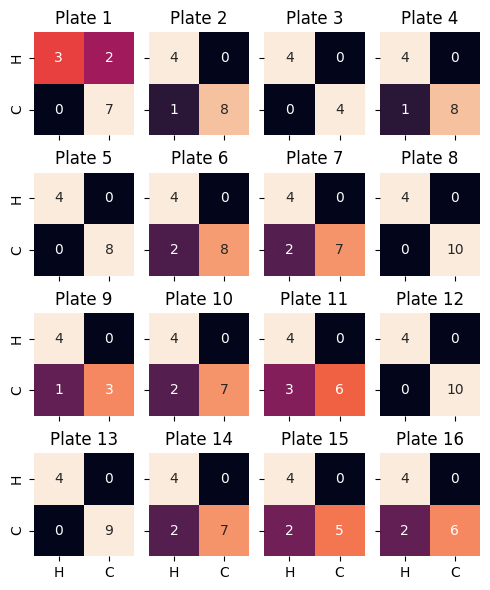

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    mat = plate_pat_df.reset_index()[plate_pat_df.reset_index()['plate'] == plate].groupby(
        ['group', 'pred_group'], observed=False)['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

### Fig. 3b

In [10]:
bag_df = bag_df.reset_index()

/tmp/ipykernel_3949008/2106022057.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
/tmp/ipykernel_3949008/2106022057.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.reset_index()[((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
/tmp/ipykernel_3949008/2106022057.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

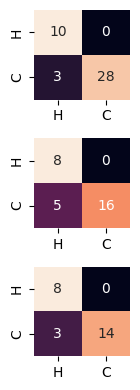

In [11]:
diags = ['H&N cancer', 'Chordoma/Chondrosarcoma', 'CNS-Meningioma']
plates = [[3, 4, 5, 6], [10, 11, 12], [7, 8, 9]]

fig, axs = plt.subplots(3, 1, figsize=(1.5, 4))
for ax, d, ps in zip(axs.flatten(), diags, plates):
    pat_df = bag_df[bag_df['plate'].isin(ps)].groupby(['pat', 'group', 'diag'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
    pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
    pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
    pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
    pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
    pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
    
    mat = pat_df.reset_index()[((pat_df.reset_index()['diag'] == d) | (pat_df.reset_index()['group'] == 'H'))].groupby(
        ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.tight_layout()

In [85]:
# model trained on all plates

name = '1_16_healthy_cancer_mil'
test_loader = test_healthy_vs_cancer_bagloader(return_chrometric=True, return_masks=True)
res_df, zs, imgs, masks, chrometrics = eval_model_with_chrometrics(name, test_loader) 

np.random.seed(1234)
vis_idx = np.concatenate([np.random.choice(np.argwhere((res_df['group'] == 'healthy').values).flatten(), replace=False, size=2500), 
                          np.random.choice(np.argwhere((res_df['group'] == 'cancer').values).flatten(), replace=False, size=2500)])
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(zs)[vis_idx])

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [86]:
correct_h_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['group'] == 'healthy')]['i'].unique()
correct_h_bags

array([  0,   1,   2,   5,   6,   7,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174])

In [87]:
correct_c_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['group'] == 'cancer')]['i'].unique()
correct_c_bags

array([175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 262, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 323, 325, 326,
       327, 328, 329, 330, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 365, 366, 368, 369, 370, 371, 37

In [88]:
res_df['total attention'] = res_df['attention 0'] + res_df['attention 1'] + res_df['attention 2'] + res_df['attention 3']  +res_df['attention 4']

In [89]:
img_array = np.array(imgs).reshape((860, 50, 1, 28, 28))
mask_array = np.array(masks).reshape((860, 50, 1, 28, 28))
img_array.shape

(860, 50, 1, 28, 28)

### Fig. 3c

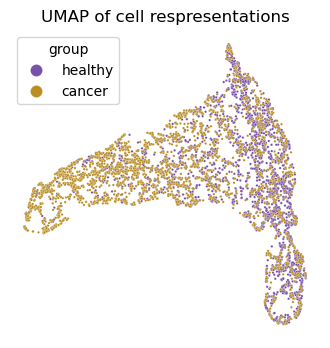

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='group', s=3, ax=ax, palette={'healthy' : '#7851A9', 'cancer' : '#BA8E23'})
ax.set_title('UMAP of cell respresentations')
sns.move_legend(ax, 'best', markerscale=5)
ax.axis('off');

### Fig. 3d

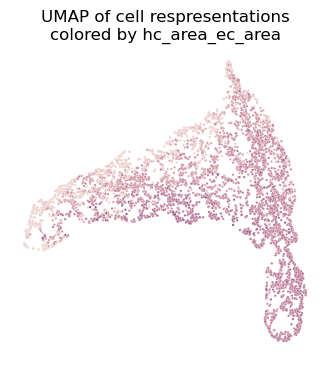

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue=chrometrics['hc_area_ec_area'], s=3, ax=ax, legend=False)
ax.set_title('UMAP of cell respresentations\ncolored by hc_area_ec_area')
# sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
ax.axis('off');

### Fig. 3e

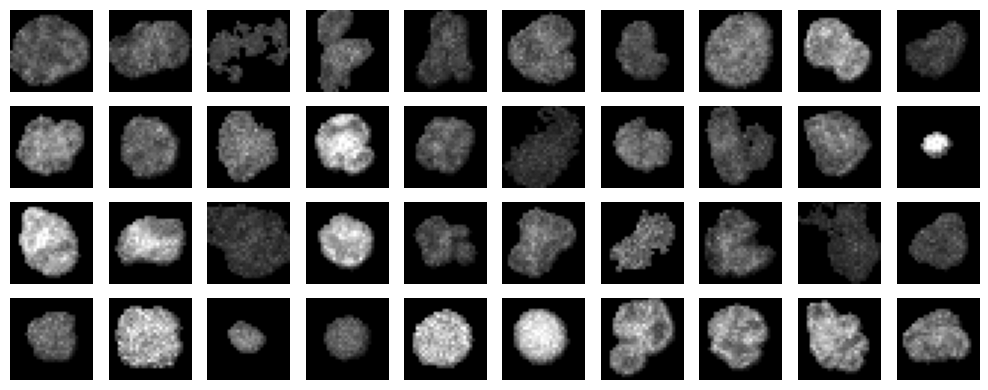

In [92]:
top_h_imgs = []
top_h_masks = []
for i in correct_h_bags:
    idx = res_df[(res_df['i'] == i) & (chrometrics['hc_area_ec_area'] > 0.1)]['total attention'].argsort().values[-3:]  # take last 3
    top_h_imgs.extend(img_array[i, idx])
    top_h_masks.extend(mask_array[i, idx])
top_h_imgs = np.array(top_h_imgs)
top_h_masks = np.array(top_h_masks)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_h_imgs)), replace=False, size=40)
for im, m, ax in zip(top_h_imgs[show_idx], top_h_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

### Fig. 3f

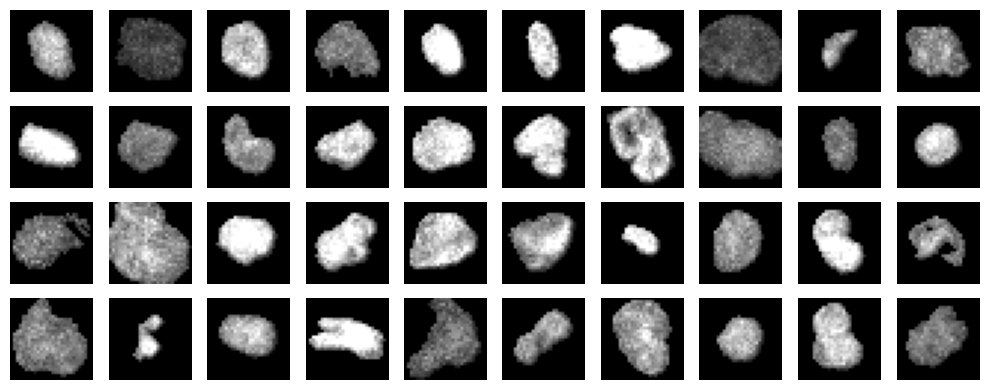

In [93]:
top_c_imgs = []
top_c_masks = []
for i in correct_c_bags:
    idx = res_df[(res_df['i'] == i) & (chrometrics['hc_area_ec_area'] < 0.01)]['total attention'].argsort().values[-3:]  # take last 3
    top_c_imgs.extend(img_array[i, idx])
    top_c_masks.extend(mask_array[i, idx])
top_c_imgs = np.array(top_c_imgs)
top_c_masks = np.array(top_c_masks)

np.random.seed(5123)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_c_imgs)), replace=False, size=40)
for im, m, ax in zip(top_c_imgs[show_idx], top_c_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

In [94]:
cnt = []
for col in chrometrics.columns[1:]:
    cnt.append((chrometrics.loc[res_df['lab'] == 0, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 0, col]), 
                chrometrics.loc[res_df['lab'] == 1, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 1, col].isna())))
cnt = pd.DataFrame(cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])
cnt
nan_cnt = cnt[(cnt['lab 0 nan'] != 0) | (cnt['lab 1 nan'] != 0)]
bad_cols = nan_cnt.index
nan_cnt

lab 0 nan  lab 0 cnt  lab 1 nan  lab 1 cnt
max_neg_curv                           879      34250        294       8750
avg_neg_curv                           879      34250        294       8750
med_neg_curv                           879      34250        294       8750
std_neg_curv                           879      34250        294       8750
sum_neg_curv                           879      34250        294       8750
len_neg_curv                           879      34250        294       8750
prominance_prominant_pos_curv         3221      34250        719       8750
width_prominant_pos_curv              3221      34250        719       8750
prominant_pos_curv                    3221      34250        719       8750
prominance_prominant_neg_curv        16061      34250       3394       8750
width_prominant_neg_curv             16061      34250       3394       8750
prominant_neg_curv                   16061      34250       3394       8750
frac_peri_w_neg_curvature              879      34250        294       8750
weighted_moments_normalized-0-0      34250      34250       8750       8750
weighted_moments_normalized-0-1      34250      34250       8750       8750
weighted_moments_normalized-1-0      34250      34250       8750       8750
moments_normalized-0-0               34250      34250       8750       8750
moments_normalized-0-1               34250      34250       8750       8750
moments_normalized-1-0               34250      34250       8750       8750

In [95]:
from scipy import stats

top_h_idx = []
for i in correct_h_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_h_idx.append(i * 50 + idx)
top_h_idx = np.concatenate(top_h_idx)

top_c_idx = []
for i in correct_c_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_c_idx.append(i * 50 + idx)
top_c_idx = np.concatenate(top_c_idx)

In [106]:
bot_h_idx = []
for i in correct_h_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_h_idx.append(i * 50 + idx)
bot_h_idx = np.concatenate(bot_h_idx)

bot_c_idx = []
for i in correct_c_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_c_idx.append(i * 50 + idx)
bot_c_idx = np.concatenate(bot_c_idx)

bot_cnt = []
for col in chrometrics.columns[1:]:
    bot_cnt.append((chrometrics.loc[bot_c_idx, col].isna().sum(), len(chrometrics.loc[bot_c_idx, col]), 
                    chrometrics.loc[bot_h_idx, col].isna().sum(), len(chrometrics.loc[bot_h_idx, col])))
bot_cnt = pd.DataFrame(bot_cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])


print(len(bot_c_idx), len(bot_h_idx), len(top_h_idx), len(top_c_idx))
m = min(len(bot_c_idx), len(bot_h_idx), len(top_h_idx), len(top_c_idx))

bot_ps_h = []
bot_ps_c = []
np.random.seed(5213)
for col in chrometrics.columns[1:]:
    bot_ps_h.append(stats.kstest(chrometrics.loc[np.random.choice(top_h_idx, size=m, replace=False).astype(int), col].values, 
                                 chrometrics.loc[np.random.choice(bot_h_idx, size=m, replace=False).astype(int), col].values).pvalue)
    bot_ps_c.append(stats.kstest(chrometrics.loc[np.random.choice(top_c_idx, size=m, replace=False).astype(int), col].values, 
                                 chrometrics.loc[np.random.choice(bot_c_idx, size=m, replace=False).astype(int), col].values).pvalue)
bot_ps_h = np.array(bot_ps_h)
bot_ps_c = np.array(bot_ps_c)
bot_cnt['p-val (healthy)'] = bot_ps_h
bot_cnt['p-val (cancer T1)'] = bot_ps_c
bot_cnt = bot_cnt[~(bot_cnt.index.isin(bad_cols))].sort_values('p-val (healthy)')

1917 495 495 1917


### Fig. S3c

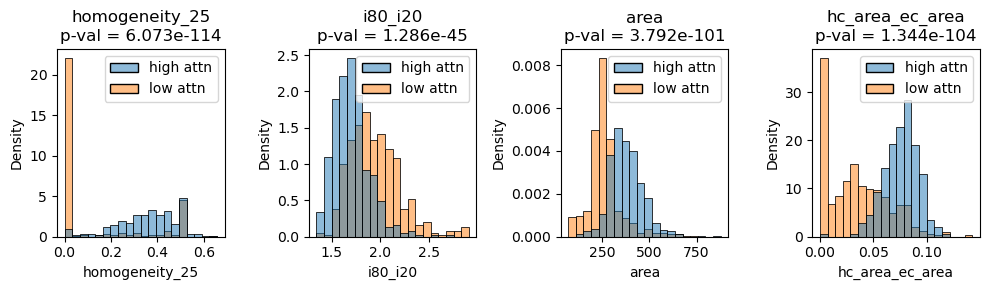

In [108]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_h_idx, bot_h_idx))], x=col, 
                 hue=['high attn'] * len(top_h_idx) + ['low attn'] * len(bot_h_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (healthy)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

### Fig. S3d

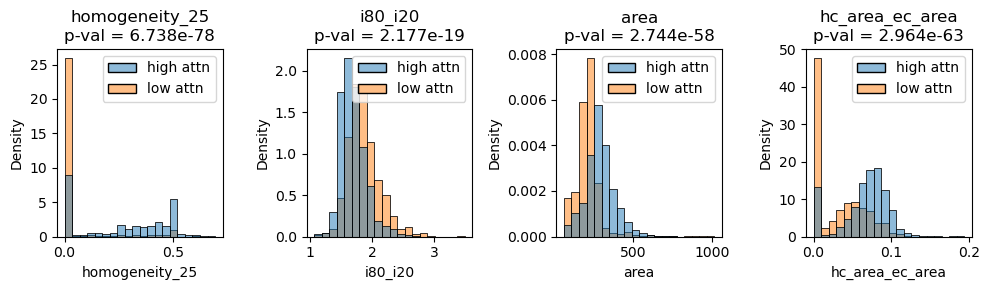

In [109]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_c_idx, bot_c_idx))], x=col, 
                 hue=['high attn'] * len(top_c_idx) + ['low attn'] * len(bot_c_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (cancer T1)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

### Fig. S3h

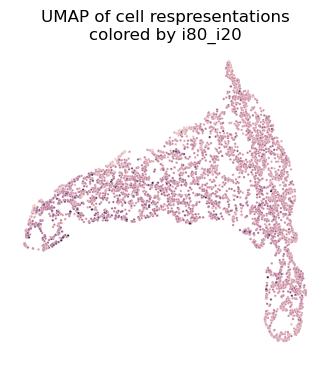

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue=chrometrics['i80_i20'].clip(1.203254396896261, 2.633803105223375), s=3, ax=ax, legend=False)
ax.set_title('UMAP of cell respresentations\ncolored by i80_i20')
ax.axis('off');

### Fig. S3e

In [111]:
chrometrics['homogeneity_25'].quantile(0.01), chrometrics['homogeneity_25'].quantile(0.99)

(0.0, 0.5411591789852366)

In [112]:
chrometrics['homogeneity_25'].quantile(0.05), chrometrics['homogeneity_25'].quantile(0.95)

(0.0, 0.5)

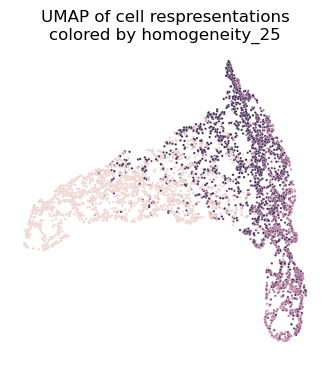

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue=chrometrics['homogeneity_25'].clip(0.0, 0.5411591789852366), s=3, ax=ax, legend=False)
ax.set_title('UMAP of cell respresentations\ncolored by homogeneity_25')
# sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
ax.axis('off');

### Fig. S3i

In [114]:
chrometrics['area'].quantile(0.01), chrometrics['area'].quantile(0.99)

(84.0, 655.0)

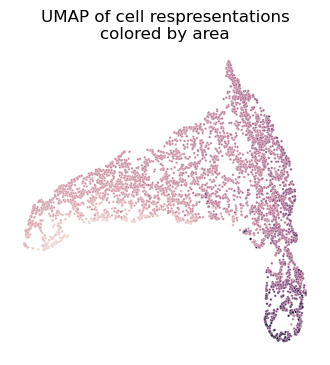

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue=chrometrics['area'].clip(84.0, 655.0), s=3, ax=ax, legend=False)
ax.set_title('UMAP of cell respresentations\ncolored by area')
# sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
ax.axis('off');

### Fig. S3g

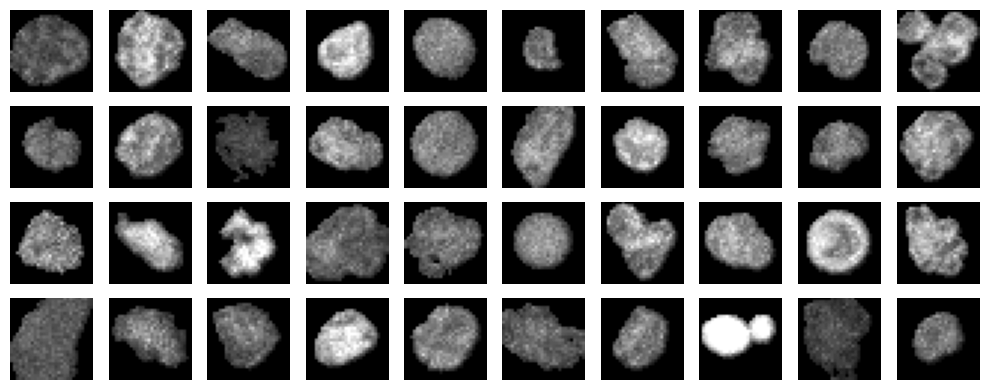

In [116]:
top_h_imgs = []
top_h_masks = []
for i in correct_h_bags:
    idx = res_df[(res_df['i'] == i) & (chrometrics['homogeneity_25'] > 0.5)]['total attention'].argsort().values[-3:]  # take last 3
    top_h_imgs.extend(img_array[i, idx])
    top_h_masks.extend(mask_array[i, idx])
top_h_imgs = np.array(top_h_imgs)
top_h_masks = np.array(top_h_masks)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_h_imgs)), replace=False, size=40)
for im, m, ax in zip(top_h_imgs[show_idx], top_h_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

### Fig. S3f

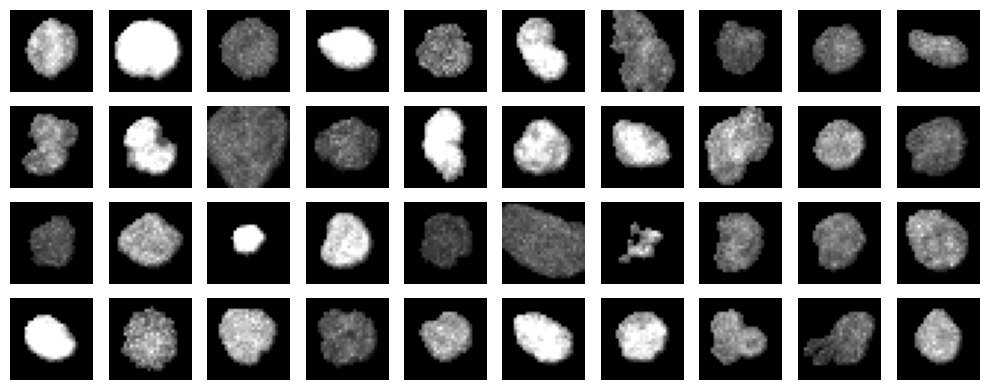

In [117]:
top_c_imgs = []
top_c_masks = []
for i in correct_c_bags:
    idx = res_df[(res_df['i'] == i) & (chrometrics['homogeneity_25'] == 0)]['total attention'].argsort().values[-3:]  # take last 3
    top_c_imgs.extend(img_array[i, idx])
    top_c_masks.extend(mask_array[i, idx])
top_c_imgs = np.array(top_c_imgs)
top_c_masks = np.array(top_c_masks)

np.random.seed(5123)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_c_imgs)), replace=False, size=40)
for im, m, ax in zip(top_c_imgs[show_idx], top_c_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

## Cancer type MIL

In [118]:
data = PlateDataset([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


In [119]:
use_plates = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
short_groups = {'healthy' : 'H', 'H&N cancer' : 'H&N', 'CNS-Meningioma' : 'M', 'Chordoma/Chondrosarcoma' : 'C/C'}  
group_map = {'healthy' : 0, 'H&N cancer' : 1, 'CNS-Meningioma' : 2, 'Chordoma/Chondrosarcoma' : 3} 

cdf = data.info[data.info['group'].isin(use_groups)].groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]
p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()


def group_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['group'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    label = np.random.choice(use_groups)
    pat = np.random.choice(pat_groups[label])
    xs = use_data[torch_random_choice(pat_lut[pat], size=bag_size)]
    label = group_map[label]
    yield xs.float(), torch.tensor(label).to(device)


def test_group_bagloader(bag_size=50, reps=5, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  pat_groups = data.info.groupby(['patient'])['group'].max()
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      xs = use_data[torch_random_choice(pat_idx, size=bag_size)]
      label = pat_groups[pat]
      yield xs.float(), torch.tensor(group_map[label]).to(device), pat, label

In [120]:
def eval_model(name, loader, branches=1, classes=1):
    if classes > 1:
      model = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      model = GatedAttention(branches=branches)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = model(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags

In [121]:
dfs = []

# leave one plate out models
for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'3_12_t01_healthy_groups_without_plate_{plate}_mil', test_group_bagloader(use_plates=[plate]), branches=5, classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
bag_df = res_without_df.groupby(['plate', 'pat', 'i'])[['pred', 'group']].max()  # same value for all (no actual max)
bag_df['pred'] = pd.Categorical(values=bag_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
bag_df['group'] = pd.Categorical(values=bag_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
bag_df['correct'] = bag_df['pred'] == bag_df['group']
bag_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.32it/s]


pred group  correct
plate pat i                     
3     H06 0     H     H     True
          1     H     H     True
          2     H     H     True
          3     H     H     True
          4     H     H     True
...           ...   ...      ...
12    P21 30    M   C/C    False
          31    M   C/C    False
          32  H&N   C/C    False
          33  H&N   C/C    False
          34  H&N   C/C    False

[545 rows x 3 columns]

/tmp/ipykernel_1375599/1896049348.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plate_pat_df = bag_df.groupby(['plate', 'pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()


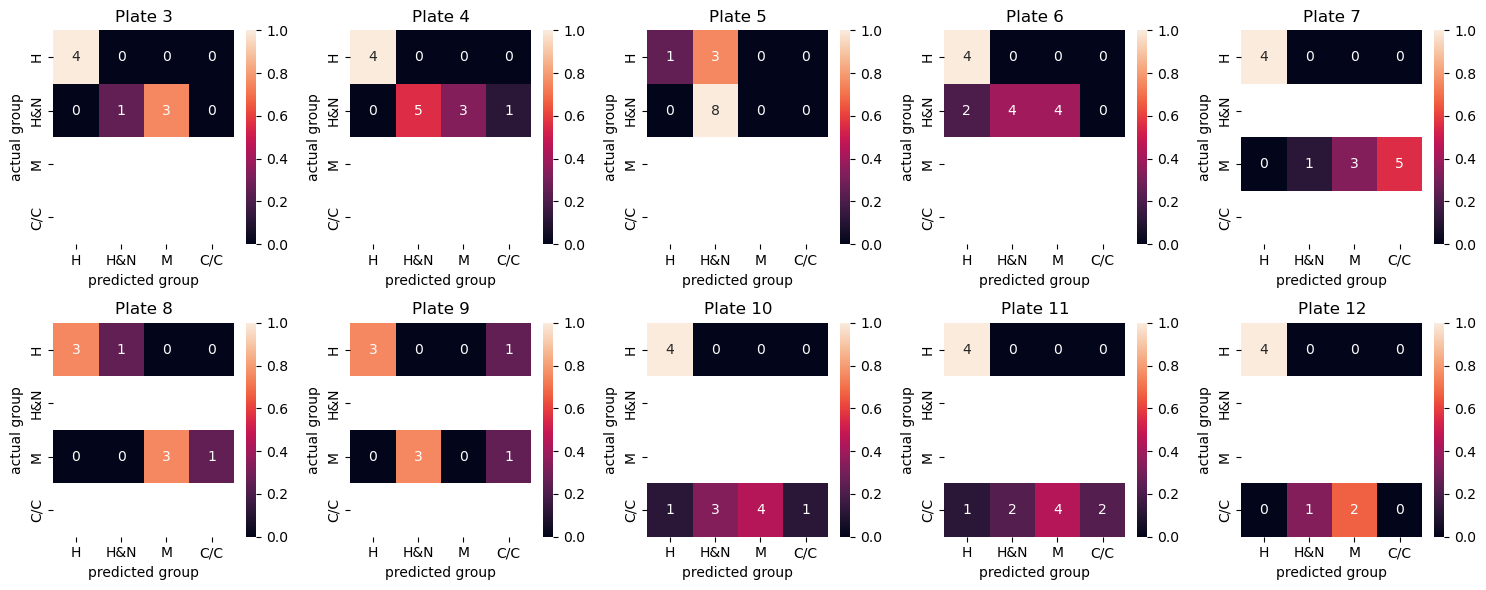

In [122]:
plate_pat_df = bag_df.groupby(['plate', 'pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
plate_pat_df['pred'] = pd.Categorical(values=plate_pat_df['pred'], categories=['H', 'H&N', 'M', 'C/C'])
plate_pat_df.set_index(['plate', 'pat', 'group'])

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = plate_pat_df.reset_index()[plate_pat_df.reset_index()['plate'] == plate].groupby(
        ['group', 'pred'], observed=False)['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

### Fig. 3g

/tmp/ipykernel_1375599/2435583737.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()


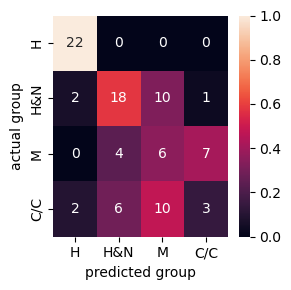

In [123]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'], categories=['H', 'H&N', 'M', 'C/C'])


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
mat = pat_df.reset_index().groupby(
    ['group', 'pred'], observed=False)['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Fig. S3b

In [124]:
# model using all data

dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('3_12_t01_healthy_groups_mil', test_group_bagloader(use_plates=[plate]), branches=5, classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)


  0%|                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.42it/s]


/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


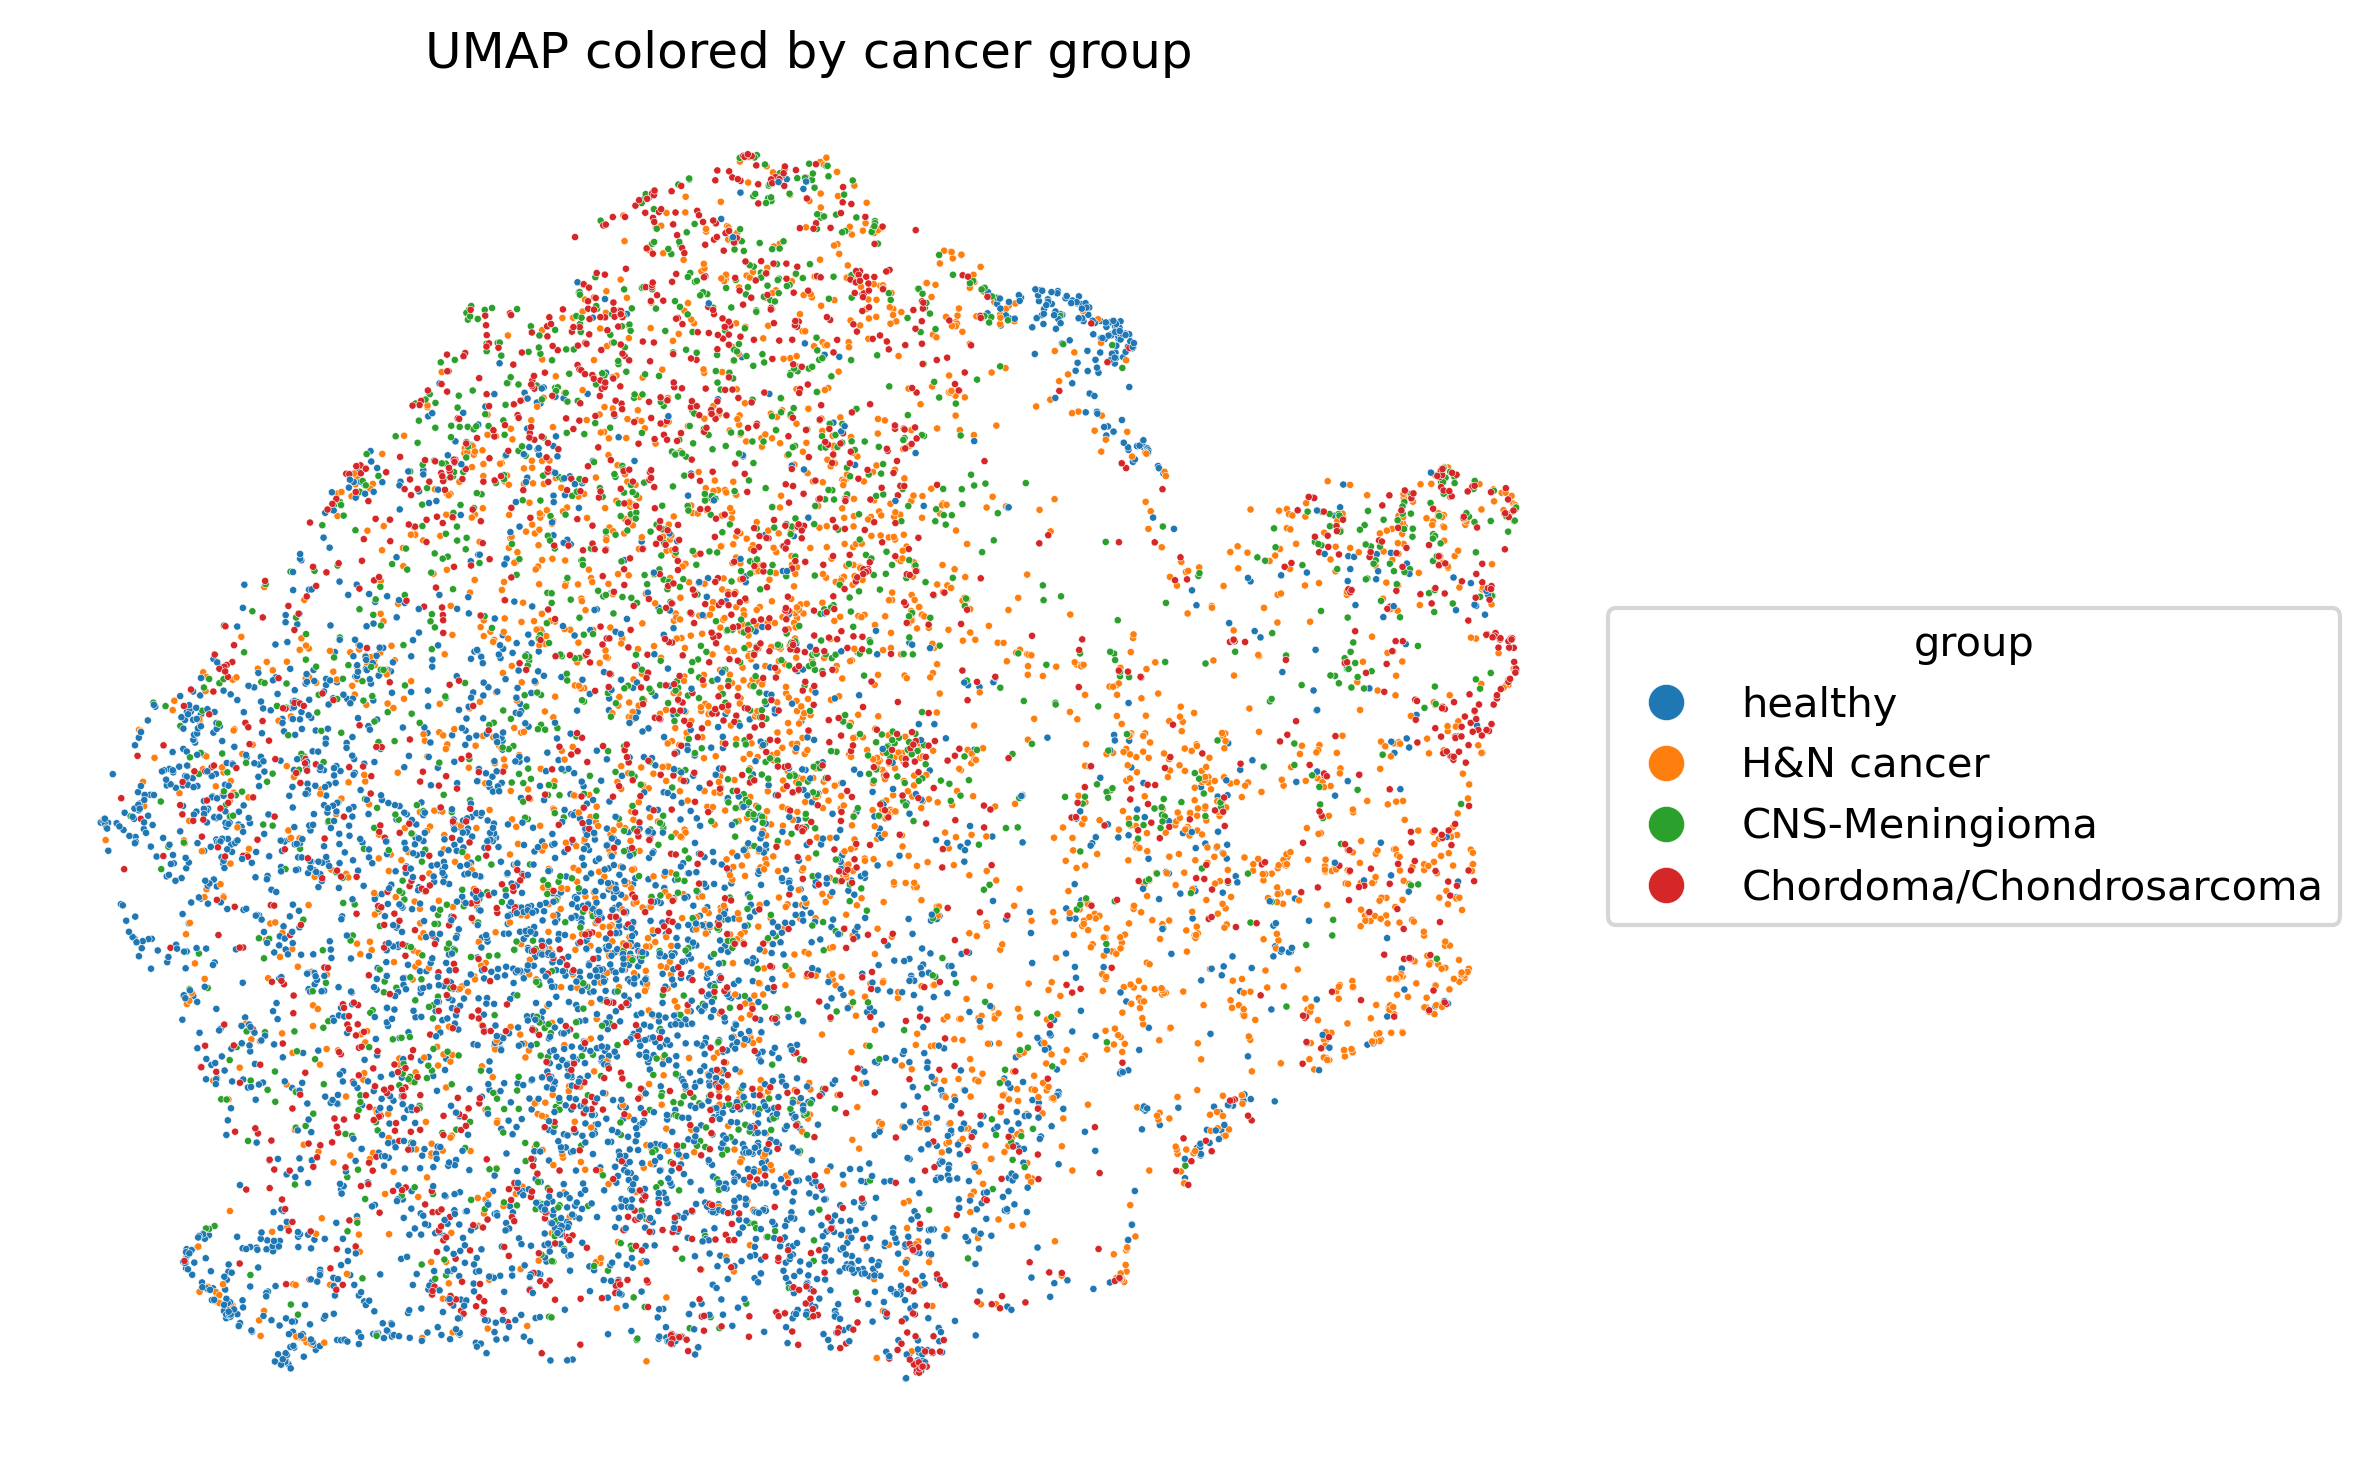

In [125]:
np.random.seed(1234)
vis_idx = np.random.choice(np.arange(len(res_df)), replace=False, size=10000)
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(bag_zs)[vis_idx])

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='group', s=3, ax=ax, palette='tab10')
ax.set_title('UMAP colored by cancer group')
sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), markerscale=5)
ax.axis('off');

fig.tight_layout()

### Fig. 3h

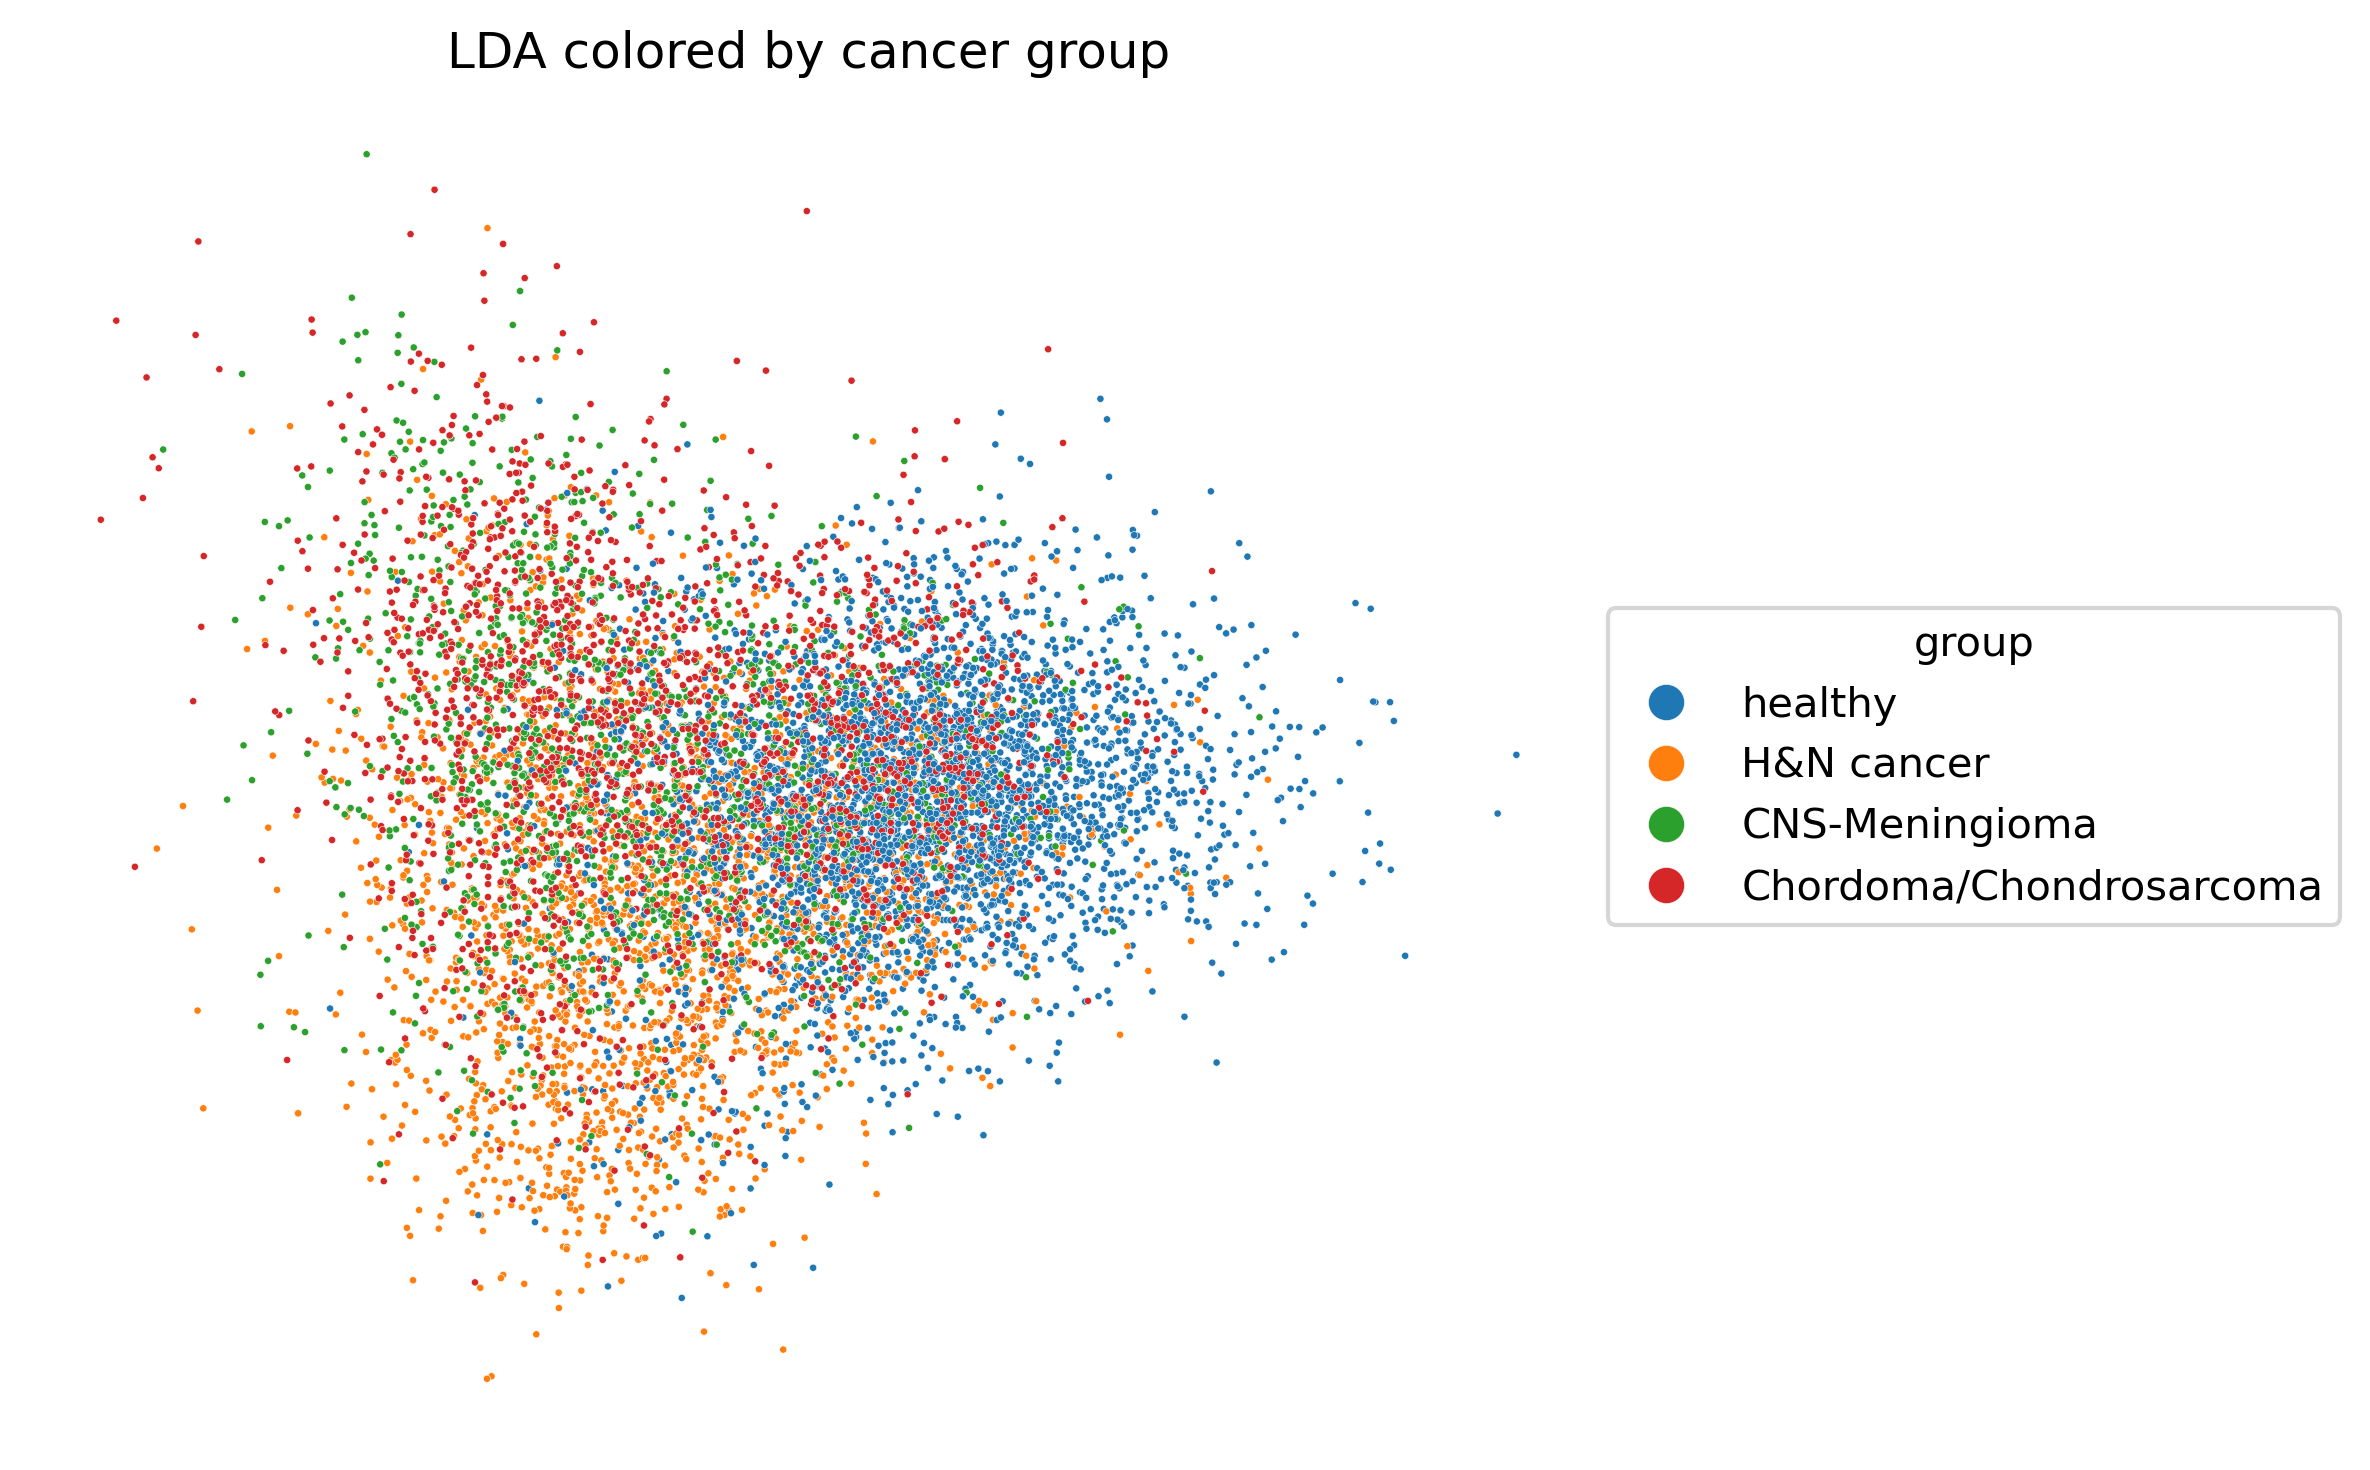

In [126]:
# from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

res_df[['lda_x', 'lda_y']] = np.nan
X = np.array(bag_zs)[vis_idx]
res_df.loc[vis_idx, ['lda_x', 'lda_y']] = LDA(n_components=2).fit(X, res_df.loc[vis_idx, 'group']).transform(X)


fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
sns.scatterplot(data=res_df, x='lda_x', y='lda_y', hue='group', s=3, ax=ax, palette='tab10')
ax.set_title('LDA colored by cancer group')
sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), markerscale=5)
ax.axis('off');

fig.tight_layout()